In [1]:
# Install necessary libraries
!pip install -U spacy scikit-learn matplotlib seaborn
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 87.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 126.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
)

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Sample dataset
data = {
    "text": [
        "I absolutely loved this film! The story was compelling and the acting superb.",
        "The movie was boring and slow-paced; I wouldn’t recommend it.",
        "It was an okay movie — nothing special but watchable.",
        "An absolute masterpiece. Brilliant direction and storytelling.",
        "Terrible plot and bad acting. A complete waste of time.",
        "It’s not bad, but it’s not good either. Very average.",
        "The cinematography was beautiful, and the soundtrack was moving.",
        "I fell asleep halfway through. Super dull and predictable.",
        "A decent film, not the best but enjoyable.",
        "Awful. One of the worst movies I've seen."
    ],
    "sentiment": [
        "Positive", "Negative", "Neutral", "Positive", "Negative",
        "Neutral", "Positive", "Negative", "Neutral", "Negative"
    ]
}

df = pd.DataFrame(data)
df.head()

,text,sentiment
0,I absolutely loved this film! The story was co...,Positive
1,The movie was boring and slow-paced; I wouldn’...,Negative
2,It was an okay movie — nothing special but wat...,Neutral
3,An absolute masterpiece. Brilliant direction a...,Positive
4,Terrible plot and bad acting. A complete waste...,Negative


In [5]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.like_num
    ]
    return " ".join(tokens)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess)
df.head()

,text,sentiment,clean_text
0,I absolutely loved this film! The story was co...,Positive,absolutely love film story compelling act superb
1,The movie was boring and slow-paced; I wouldn’...,Negative,movie boring slow paced recommend
2,It was an okay movie — nothing special but wat...,Neutral,okay movie special watchable
3,An absolute masterpiece. Brilliant direction a...,Positive,absolute masterpiece brilliant direction story...
4,Terrible plot and bad acting. A complete waste...,Negative,terrible plot bad acting complete waste time


In [6]:
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [7]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

pipeline_nb.fit(X_train, y_train)
y_pred = pipeline_nb.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       0.50      1.00      0.67         1
     Neutral       1.00      1.00      1.00         1
    Positive       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



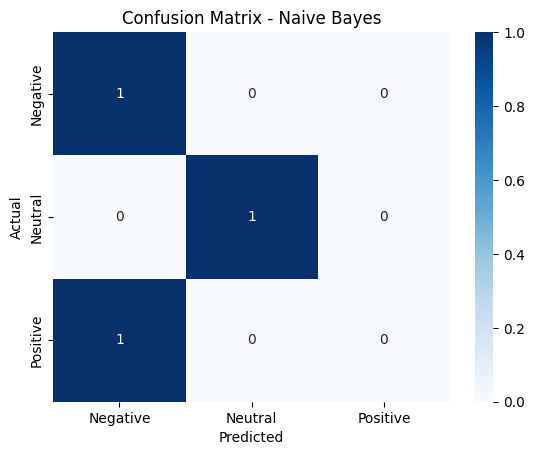

In [8]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [9]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier()
}

results = []
for name, model in models.items():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc, f1))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
results_df.sort_values(by="F1 Score", ascending=False)

,Model,Accuracy,F1 Score
0,Naive Bayes,0.666667,0.555556
1,Logistic Regression,0.666667,0.555556
3,Random Forest,0.666667,0.555556
2,SVM,0.333333,0.166667


In [10]:
vectorizers = {
    "TF-IDF Unigram": TfidfVectorizer(ngram_range=(1,1)),
    "TF-IDF Bigram": TfidfVectorizer(ngram_range=(1,2)),
    "TF-IDF Trigram": TfidfVectorizer(ngram_range=(1,3)),
}

for name, vec in vectorizers.items():
    pipeline = Pipeline([
        ('vectorizer', vec),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"{name} -> F1 Score: {f1_score(y_test, y_pred, average='macro'):.3f}")

TF-IDF Unigram -> F1 Score: 0.556
TF-IDF Bigram -> F1 Score: 0.167
TF-IDF Trigram -> F1 Score: 0.167


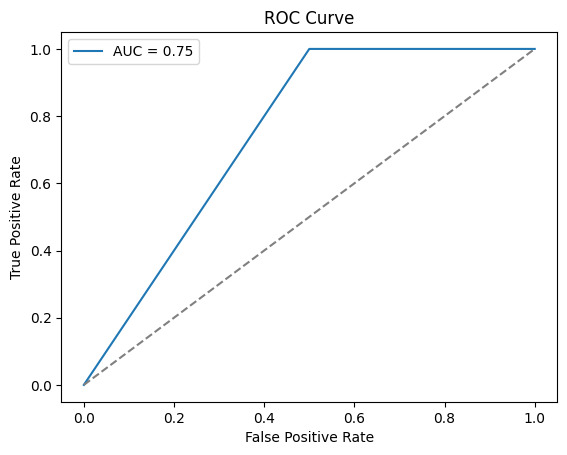

In [11]:
# For binary case, simplify to Positive vs Negative
df_binary = df[df['sentiment'] != 'Neutral']
Xb = df_binary['clean_text']
yb = df_binary['sentiment'].map({'Positive': 1, 'Negative': 0})

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])
pipeline.fit(Xb_train, yb_train)
y_probs = pipeline.predict_proba(Xb_test)[:, 1]

fpr, tpr, _ = roc_curve(yb_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [12]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.8, 1.0],
    'clf__C': [0.1, 1, 10]
}

grid = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best F1 Score:", grid.best_score_)

Best Parameters: {'clf__C': 1, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 1)}
Best F1 Score: 0.27777777777777773


In [13]:
custom_review = "The movie was visually stunning but lacked substance."
clean_review = preprocess(custom_review)
pred_label = grid.predict([clean_review])[0]
confidence = max(grid.predict_proba([clean_review])[0])

print(f"Predicted Sentiment: {pred_label} (Confidence: {confidence:.2f})")

Predicted Sentiment: Negative (Confidence: 0.49)
